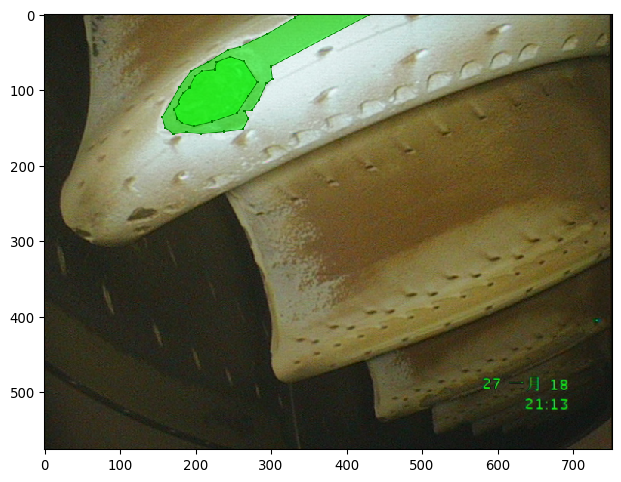

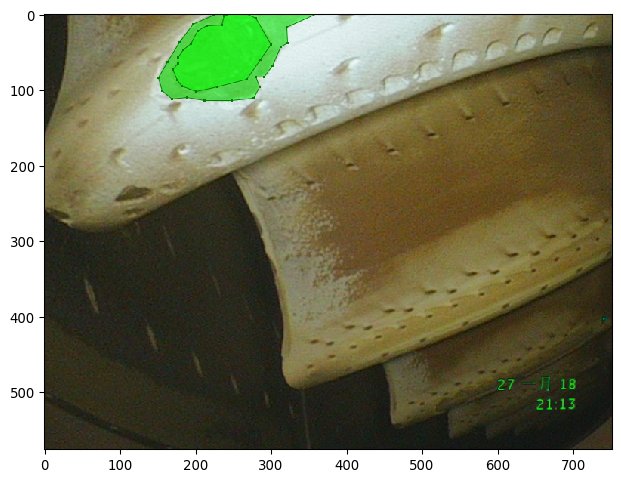

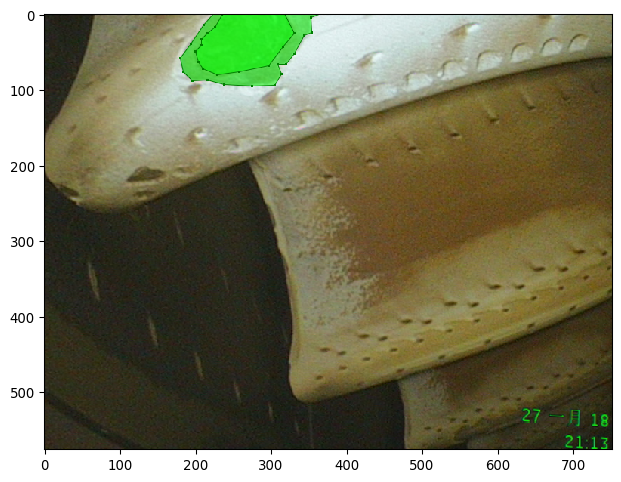

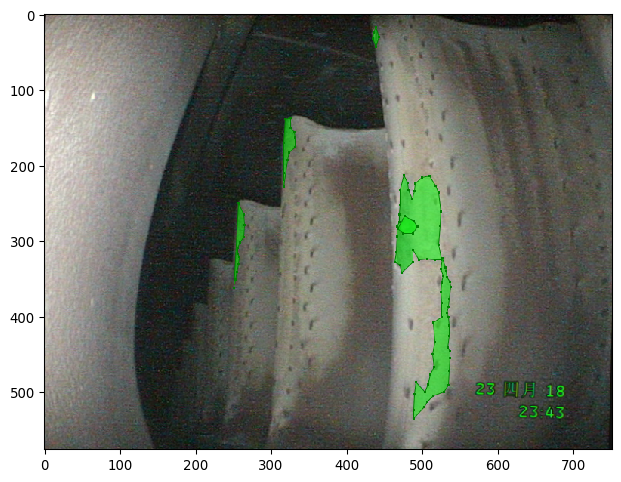

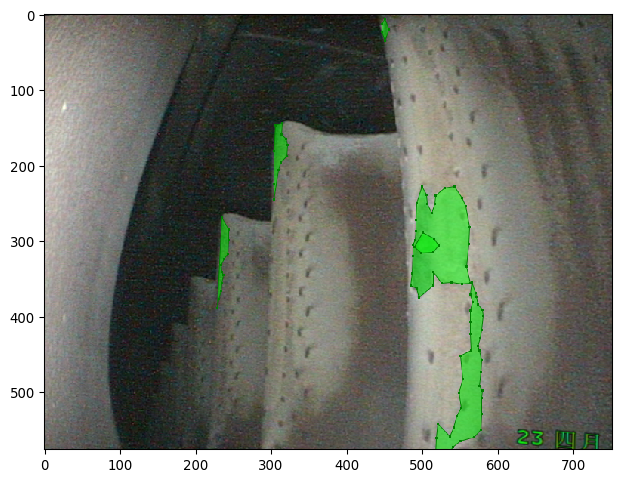

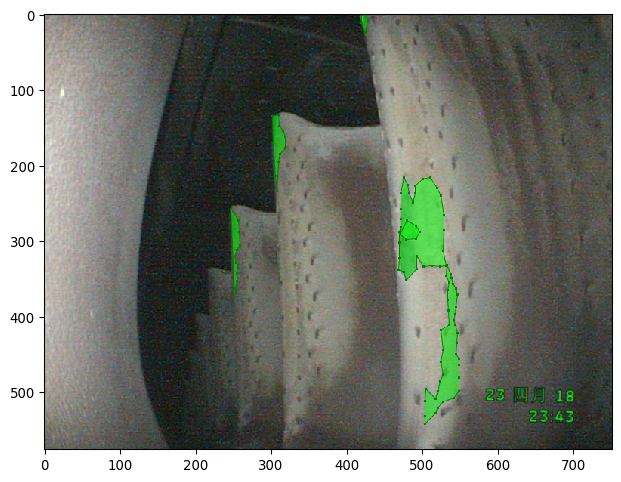

time cost 3.711026906967163 s


In [9]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.polys import Polygon, PolygonsOnImage
import numpy as np
import json
import shutil
import os
import re
import time
import base64
from imgaug.augmentables.batches import UnnormalizedBatch

json_src_dir=r'/home/cver/lcx/data/augmentation/imgaug1json'
img_src_dir=r'/home/cver/lcx/data/augmentation/imgaug1img'
json_dst_dir=r'/home/cver/lcx/data/augmentation/json_dst'
img_dst_dir=r'/home/cver/lcx/data/augmentation/img_dst'
extend_times=3


def load_images(path):#读入图像
    all_images=[]
    for file in sorted(os.listdir(path)):
        image = imageio.imread(os.path.join(path,file))
        all_images.append(image)
    return all_images

def load_json_polygons(path):#读入全部json
    all_polygons=[]
    for file in sorted(os.listdir(path)):
        with open(os.path.join(path,file),'r') as fp:
            data = json.load(fp)  # 加载json文件
            point_set=[]#初始的多边形节点集合
            for s_i,data_shapes in enumerate(data["shapes"]):  
                temp = np.array(data["shapes"][s_i]["points"])#list转numpy.array
                temp=np.round(temp).astype(np.int16)#四舍五入然后转为整数
                arr = temp.tolist()#numpy.array转list
                arr=Polygon(arr,label=data["shapes"][s_i]["label"])#转为imgaug模块对多边形节点的格式要求
                point_set.append(arr)
            psoi = ia.PolygonsOnImage(point_set,shape=(data["imageHeight"],data["imageWidth"],3))
            all_polygons.append(psoi)
    return all_polygons

def batches_augmenter(all_images,all_polygons):
    batches = [UnnormalizedBatch(images=all_images, polygons=all_polygons) for _ in range(extend_times)] 

    aug = iaa.Sequential([#扩展策略
    #     iaa.Flipud(0.5),#上下镜像翻转#*2
    #     iaa.Fliplr(0.5),#左右镜像翻转#*2 
    #     iaa.GammaContrast(gamma=(0.5, 2.0),per_channel=True, random_state=None),#伽玛对比度#*6
    #     iaa.MotionBlur(k=(3,20),angle=(0,360), direction=(-1.0, 1.0),random_state=None)#移动模糊，步长k，图像平面上的移动方向angle，图像法向的移动方向direction，random_state？
            iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True)#透视变换#一个多边形变换后可能变成0,1,2...任意多的多边形，imgaug0.3.0 not implement yet
    #     iaa.GaussianBlur(sigma=(0.0, 5.0))#高斯模糊
        ])

    batches_aug = list(aug.augment_batches(batches, background=True))#background=True
    return batches_aug

def images_write(batches_aug,src_dir,dst_dir):
    for j,imgName in enumerate(sorted(os.listdir(src_dir))):
        for i,batches in enumerate(batches_aug):
            
            ia.imshow(
                batches_aug[i].polygons_aug[j].draw_on_image(
                    batches_aug[i].images_aug[j]
                )
            )
            imageio.imwrite(os.path.join(dst_dir,json_image_aug_Path(i,imgName)[2]),
                            batches_aug[i].images_aug[j])
def jsons_dump(batches_aug,src_dir,dst_dir):
    for j,jsonName in enumerate(sorted(os.listdir(src_dir))):
        with open(os.path.join(src_dir,jsonName),'r') as fp:
            data = json.load(fp)
            for i,batches in enumerate(batches_aug):
                batches_aug[i].polygons_aug[j]=batches_aug[i].polygons_aug[j].clip_out_of_image()
                data["imagePath"]=json_image_aug_Path(i,jsonName)[2]
                data["imageData"]=json_imageData(json_image_aug_Path(i,jsonName)[2])
                data["shapes"]=json_shapes(batches_aug[i].polygons_aug[j])
            
                json.dump(data,open(os.path.join(dst_dir,json_image_aug_Path(i,jsonName)[1]),
                                    'w'), indent=4,ensure_ascii=False)

def json_image_aug_Path(i,fullName):
    temp=[]
    name=os.path.basename(fullName).split('.')[0]
    temp.append(name)                                       
    temp.append(name+"_Aug"+str(i+1)+".json") 
    temp.append(name+"_Aug"+str(i+1)+".png")
    return temp
                                              
def json_imageData(fileName):
#     for file in os.listdir(img_dst_dir):
#         matchObj = re.search(fileName.split('.')[0], file)
#         if matchObj:
#             print(fileName.split('.')[0],file)
#             with open(os.path.join(img_dst_dir,file),'rb') as f:
    with open(os.path.join(img_dst_dir,fileName),'rb') as f:
        imageData=base64.b64encode(f.read()).decode('utf-8')
        return imageData
    
def json_shapes(PolygonsOnImage):
    shapes=[]
    for i,polygon in enumerate(PolygonsOnImage.polygons):
        shape={}
        shape.update({"line_color": 0,"fill_color": 0,
                      "shape_type": "polygon","flags": {},
                      "label" : polygon.label,
                      "points" : polygon.exterior.astype(np.int16).tolist()
                      })
        
        shapes.append(shape)
    
    return shapes

def main():
    time_start=time.time()
    
    batches_aug=batches_augmenter(load_images(img_src_dir),
                                  load_json_polygons(json_src_dir))
    images_write(batches_aug,img_src_dir,img_dst_dir)
    jsons_dump(batches_aug,json_src_dir,json_dst_dir)
    
    time_end=time.time()
    print('time cost',time_end-time_start,'s')
    
if __name__ == "__main__":
    main()

In [2]:
import imageio
import os
# image = imageio.imread(r'/home/cver/Desktop/Screenshot from 2019-09-27 09-33-39.png')
# print(image.shape)
a=os.path.basename(r'/home/cver/Desktop/Screenshot from 2019-09-27 09-33-39.png').split('.')[0]
print(a)
print(a.split('.')[0])

Screenshot from 2019-09-27 09-33-39
Screenshot from 2019-09-27 09-33-39


# 一级标题
## 二级标题


In [28]:
a=[2,4,5]
for i,aa in enumerate(a):
    print(i,aa)

0 2
1 4
2 5
